In [5]:
#Library imports
import re
import time
import math
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from fbprophet import Prophet
from pylab import rcParams
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_cross_validation_metric
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf

#User Created functions
from cleaning_functions import *
from eda_functions import *
from modeling_functions import *
# from keras_wrapper_fix import Keras_Custom_Fitter

#Notebook arguments
%matplotlib inline

Importing plotly failed. Interactive plots will not work.


Our main dataset (https://www.kaggle.com/sudalairajkumar/cryptocurrencypricehistory) was pulled from Kaggle. It contains data from a selection of various cyptocurrencies where price data was scraped from CoinMarketCap which in the timeline of the crptocurrency market had early on established itself as a popular player in providing market data from this new asset class

In [6]:
btc=pd.read_pickle("bitcoin.pickle")

# importing bitcoin data

In [7]:
type(btc)

#checking type

pandas.core.frame.DataFrame

In [8]:
btc.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2020-05-02,8869.06,9007.19,8811.37,8988.60,4.013439e+10,165012307600
2020-05-01,8672.78,9048.02,8667.76,8864.77,4.406839e+10,162722652380
2020-04-30,8797.67,9440.65,8533.26,8658.55,6.696463e+10,158922133909
2020-04-29,7806.71,8871.75,7786.05,8801.04,6.020105e+10,161522471385
2020-04-28,7796.97,7814.53,7730.81,7807.06,3.318796e+10,143266252261


# Data Preprocessing ##

In [9]:
btc = btc.sort_index()
btc = btc.asfreq("D")

# sorting data frame

In [10]:
btc.head()

#values sorted 

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2013-04-28,135.30,135.98,132.10,134.21,NaN,1500520000
2013-04-29,134.44,147.49,134.00,144.54,NaN,1491160000
2013-04-30,144.00,146.93,134.05,139.00,NaN,1597780000
2013-05-01,139.00,139.89,107.72,116.99,NaN,1542820000
2013-05-02,116.38,125.60,92.28,105.21,NaN,1292190000


In [11]:
btc.tail()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2020-04-28,7796.97,7814.53,7730.81,7807.06,3.318796e+10,143266252261
2020-04-29,7806.71,8871.75,7786.05,8801.04,6.020105e+10,161522471385
2020-04-30,8797.67,9440.65,8533.26,8658.55,6.696463e+10,158922133909
2020-05-01,8672.78,9048.02,8667.76,8864.77,4.406839e+10,162722652380
2020-05-02,8869.06,9007.19,8811.37,8988.60,4.013439e+10,165012307600


In [12]:
df = pd.DataFrame(btc).reset_index()
df

# resetting index 

,Date,Open,High,Low,Close,Volume,Market Cap
0,2013-04-28,135.30,135.98,132.10,134.21,NaN,1500520000
1,2013-04-29,134.44,147.49,134.00,144.54,NaN,1491160000
2,2013-04-30,144.00,146.93,134.05,139.00,NaN,1597780000
3,2013-05-01,139.00,139.89,107.72,116.99,NaN,1542820000
4,2013-05-02,116.38,125.60,92.28,105.21,NaN,1292190000
...,...,...,...,...,...,...,...
2557,2020-04-28,7796.97,7814.53,7730.81,7807.06,3.318796e+10,143266252261
2558,2020-04-29,7806.71,8871.75,7786.05,8801.04,6.020105e+10,161522471385
2559,2020-04-30,8797.67,9440.65,8533.26,8658.55,6.696463e+10,158922133909
2560,2020-05-01,8672.78,9048.02,8667.76,8864.77,4.406839e+10,162722652380


In [13]:
df = df.rename(columns={'Date': 'ds', 'Close': 'y'})

# renaming columns as required by Prophet

In [14]:
df.head()

,ds,Open,High,Low,y,Volume,Market Cap
0,2013-04-28,135.30,135.98,132.10,134.21,NaN,1500520000
1,2013-04-29,134.44,147.49,134.00,144.54,NaN,1491160000
2,2013-04-30,144.00,146.93,134.05,139.00,NaN,1597780000
3,2013-05-01,139.00,139.89,107.72,116.99,NaN,1542820000
4,2013-05-02,116.38,125.60,92.28,105.21,NaN,1292190000


In [15]:
df.drop(['Open','High','Volume','Market Cap','Low'], axis=1, inplace=True)

# dropping irrelevant columns

In [16]:
df.head()

# sanity check

,ds,y
0,2013-04-28,134.21
1,2013-04-29,144.54
2,2013-04-30,139.00
3,2013-05-01,116.99
4,2013-05-02,105.21


Now that we have preprocessed out data with column names as required by Prophet we are ready to start building our model

## Prophet Model Buildout ##

In [17]:
m = Prophet(daily_seasonality=True, interval_width=0.95)

# Instantiate prophet model m

In [18]:
m.fit(df)

# fit model to dataframe df

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Time to make some predictions using Prophet future_dataframe method

In [19]:
future = m.make_future_dataframe(periods=15, freq='D')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# create test dataframe 'future' with 30 daily observations

,ds,yhat,yhat_lower,yhat_upper
2572,2020-05-13,10193.096837,7804.003084,12379.224089
2573,2020-05-14,10206.200721,7951.170615,12382.842852
2574,2020-05-15,10238.268042,8061.488321,12522.232755
2575,2020-05-16,10263.196349,7999.054520,12509.797709
2576,2020-05-17,10270.512797,8105.620025,12499.186361


## Visualising Forecasts using a 95% confidence interval##

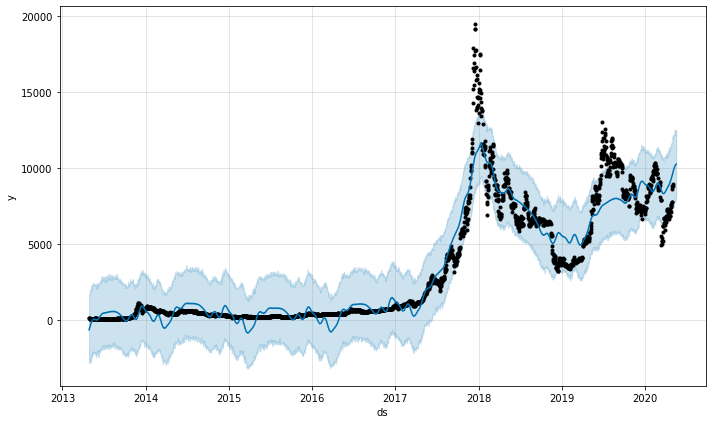

In [20]:
fig1 = m.plot(forecast)

# plotting forecast values (blue outline refers to 95% confidence interval) and actual observations (black dots represent actual values of y)

If you want to see the forecast components, we can use the Prophet.plot_components method. By default you’ll see the trend, yearly seasonality, and weekly seasonality of the time series. If you include holidays, you’ll see those here, too

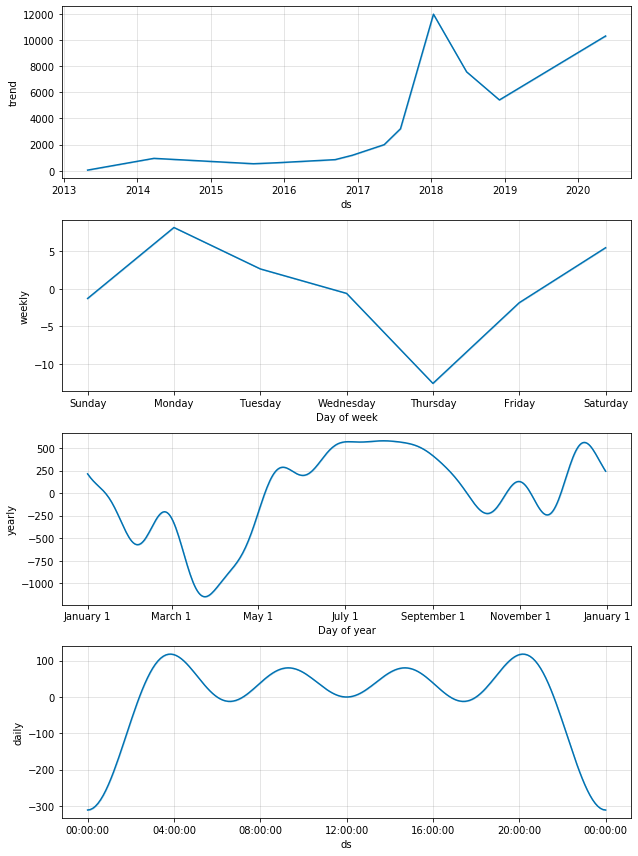

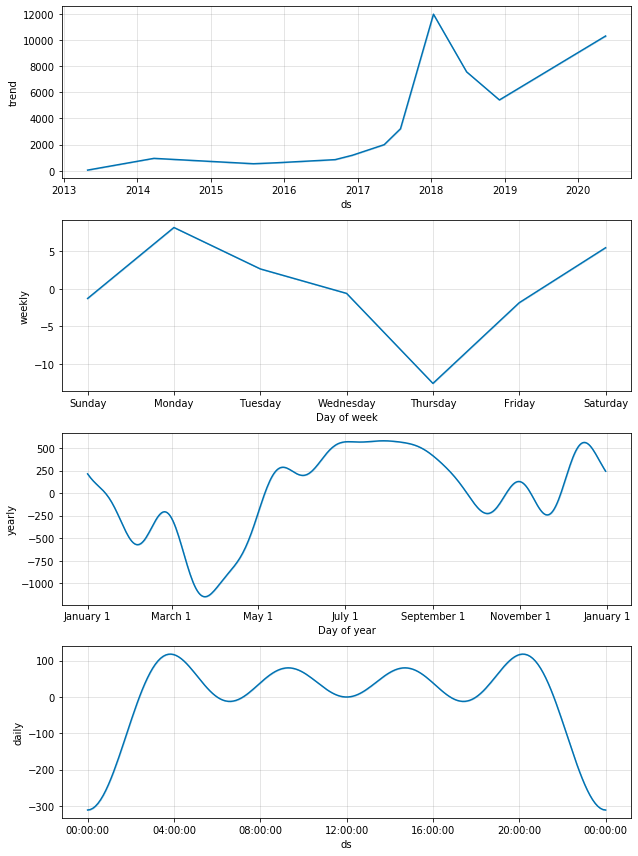

In [136]:
m.plot_components(forecast)

# plotting components of forecast like trend - weekly,yearly and daily 

Interpretation 
1. Daily - there are no inter-day trend so to speak of.
2. Weekly - again there is no clear trend other than to reflect the all week trading cycle of bitcoin
3. Overall Trend - seems to point to an upward trend in pricing of bitcoin


## Identifying and plotting Changepoints in Data##

Prophet detects changepoints by first specifying a large number of potential changepoints at which the rate is allowed to change. It then puts a sparse prior on the magnitudes of the rate changes (equivalent to L1 regularization) - this essentially means that Prophet has a large number of possible places where the rate can change, but will use as few of them as possible

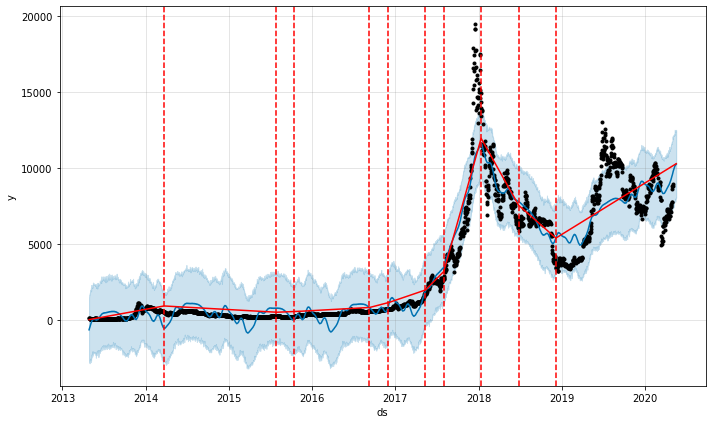

In [21]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

# plotting changepoints for dataset 

Clearly there are critical phases on change in our data as reflected by the change points

## Exploring input argument for trend in forecasts ##

If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength of the sparse prior using the input argument changepoint_prior_scale. By default, this parameter is set to 0.05. Increasing it will make the trend more flexible. While we did explore playing around with the input argument, we were not able to achieve any meaningful difference in forecasts so left it at the default input only 

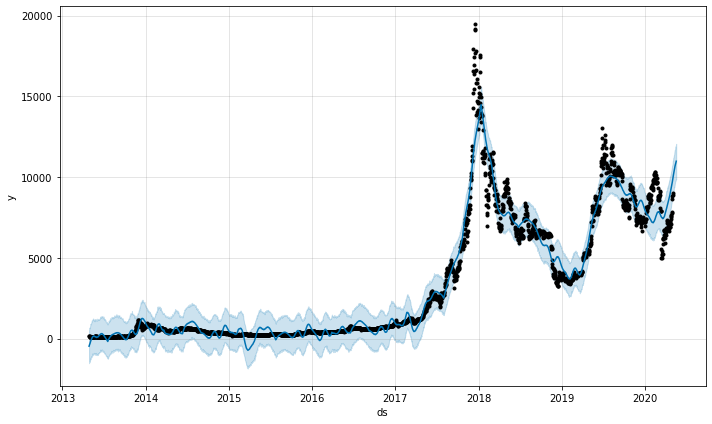

In [23]:
m = Prophet(changepoint_prior_scale=0.5, daily_seasonality=True)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)

# evaluating impact of trend using parameter changepoint_prior_scale

# Diagnostics ##

Prophet includes functionality for time series cross validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values

In [25]:
# Python
df_cv = cross_validation(m, initial='2532 days', period='15 days', horizon = '15 days')
df_cv.head()

# using CV function in fprophet to make predictions for 15 days using an initial training set of 2532 observations

INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-04-17 00:00:00 and 2020-04-17 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-04-18,9241.391879,8201.410140,10200.360081,7257.66,2020-04-17
1,2020-04-19,9305.739194,8372.958511,10278.678934,7189.42,2020-04-17
2,2020-04-20,9390.578759,8446.644327,10279.912688,6881.96,2020-04-17
3,2020-04-21,9460.721446,8474.388415,10339.711497,6880.32,2020-04-17
4,2020-04-22,9531.318073,8515.082284,10463.105652,7117.21,2020-04-17


In [26]:
df_p = performance_metrics(df_cv)
df_p.head()

# Generating performance metrics to evaluate forecasts

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,3.935192e+06,1983.731879,1983.731879,0.273329,0.273329,0.0
1,2 days,4.478807e+06,2116.319194,2116.319194,0.294366,0.294366,0.0
2,3 days,6.293168e+06,2508.618759,2508.618759,0.364521,0.364521,0.0
3,4 days,6.658472e+06,2580.401446,2580.401446,0.375041,0.375041,0.0
4,5 days,5.827918e+06,2414.108073,2414.108073,0.339193,0.339193,0.0


Clearly the model is struggling to predict with a RMSE of 1961 for a 1 day prediction horizion with RMSE increasing with an increase in prediction horizon

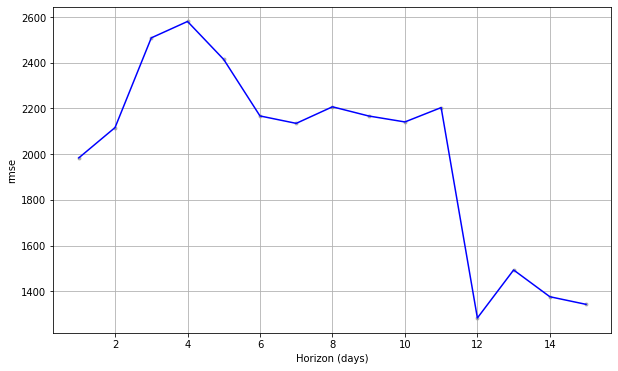

In [27]:
fig3 = plot_cross_validation_metric(df_cv, metric='rmse')

# evaluating performance using rmse 

Clearly the lowest RMSE is for the 12 day forecast

In conclusion, Prophet didnt have the best rmse but it easy to use and intutive to understand. Further it requires minimum pre-processing of data and can be easily modified to account for liner and non-linear trends in the data.